In [1]:
import json
from copy import copy
import matplotlib.pyplot as plt
import yaml
import optuna
import numpy as np
from optuna.samplers import CmaEsSampler, TPESampler

from utils import denoise_small_values, generate_sinc_filter, generate_filter, oversample
from snn.resonator import test_resonator_on_chirp, lf_lp_options

In [2]:
from snn.spiking_network import SpikingNetwork
from snn.layers import SCTNLayer
from snn.spiking_neuron import create_SCTN, IDENTITY


def oversample(signal, num_samples):
    original_length = signal.shape[0]
    indices = np.linspace(0, original_length - 1, num_samples)
    interpolated_signal = np.interp(indices, np.arange(original_length), signal)
    return interpolated_signal

def neuron_output(neuron, rolling_window, duration, signal_freq):
    y_events = neuron.out_spikes()
    y_events = y_events[(y_events > (duration - (7/signal_freq)) * clk_freq) & (y_events < (duration - (2/signal_freq)) * clk_freq)]
    if len(y_events) == 0:
        raise ValueError("No spikes were emit.")
    y_events -= y_events[0]
    y_spikes = np.zeros(int(5/signal_freq * clk_freq) + 1)
    y_spikes[y_events] = 1
    y_spikes_rollsum = np.convolve(y_spikes, np.ones(rolling_window, dtype=int), 'valid')
    return y_spikes_rollsum

def generate_n_input_signal(resonator, duration, f):
    x = np.linspace(0, duration, int(duration * resonator.clk_freq))
    t = x * 2 * np.pi * f
    sine_wave = np.sin(t)
    resonator.input_full_data(sine_wave)

def resonator_from_optuna(lf_lp_option, theta_input, theta, weight_input, weight_feedback, weight, amplitude_gain=1, clk_freq=1_536_000):
    LF, LP, f_resonator = lf_lp_options(freq0, clk_freq)[lf_lp_option]
    network = SpikingNetwork(clk_freq)
    network.add_amplitude(1000 * amplitude_gain)

    # Encode to pdm
    neuron = create_SCTN()
    neuron.activation_function = IDENTITY
    network.add_layer(SCTNLayer([neuron]))

    # SCTN 1
    neuron = create_SCTN()
    neuron.synapses_weights = np.array([weight_input, -weight_feedback], dtype=np.float64)
    neuron.leakage_factor = LF
    neuron.leakage_period = LP
    neuron.theta = theta_input
    neuron.activation_function = IDENTITY
    neuron.membrane_should_reset = False
    network.add_layer(SCTNLayer([neuron]))

    for i in range(3):
        neuron = create_SCTN()
        neuron.synapses_weights = np.array([weight], dtype=np.float64)
        neuron.leakage_factor = LF
        neuron.leakage_period = LP
        neuron.theta = theta
        neuron.activation_function = IDENTITY
        neuron.membrane_should_reset = False
        network.add_layer(SCTNLayer([neuron]))

    # feedback
    network.connect_by_id(4, 1)
    return network

def shift(signal, shift_by, waves):
    delta = np.zeros(len(signal))
    wave_length = len(signal)/waves
    shift_by *= wave_length/(2*np.pi)
    delta[int(shift_by)] = 1.0
    fft_delta = np.fft.fft(delta)
    fft_signal = np.fft.fft(signal)*fft_delta
    shifted_signal = np.fft.ifft(fft_signal)
    return shifted_signal.real

def objective(trial):
    # lf_lp_option=trial.suggest_int('lf_lp_option', 0, len(_lf_lp_options)-1)
    theta_input=trial.suggest_float('theta_input', -10, 0)
    theta=trial.suggest_float('theta', -15, 0)
    weight_input=trial.suggest_float('weight_input', 5, 20)
    weight_feedback=trial.suggest_float('weight_feedback', 5, 20)
    weight=trial.suggest_float('weight', 5, 20)
    # amplitude_gain=trial.suggest_float('amplitude_gain', 0, 10)
    amplitude_gain=1

    resonator = resonator_from_optuna(lf_lp_option, theta_input, theta, weight_input, weight_feedback, weight, amplitude_gain, clk_freq)
    return  score_resonator(resonator, duration=.3, freq0=freq0)

def score_resonator(resonator, duration, freq0, plot=False):
    for i in range(0, 5):
        resonator.log_out_spikes(i)

    x = np.linspace(0, duration, int(duration * resonator.clk_freq))
    t = x * 2 * np.pi * freq0
    sine_wave = np.sin(t)
    resonator.input_full_data(sine_wave)
    # try:
    #     spikes_roll0 = neuron_output(resonator.neurons[0], spikes_window_size, duration, signal_freq=freq0)
    #     max_spikes0 = np.max(spikes_roll0)
    #     min_spikes0 = np.min(spikes_roll0)
    #     mean_spikes0 = np.mean(spikes_roll0)
    #     normalize_roll0 = (spikes_roll0-min_spikes0)/(max_spikes0 - min_spikes0)
    #     normalize_roll0 = normalize_roll0*2-1
    #     resonator.neurons[0].forget_logs()
    #
    #     spikes_roll1 = neuron_output(resonator.neurons[-1], spikes_window_size, duration, signal_freq=freq0)
    #     max_spikes1 = np.max(spikes_roll1)
    #     min_spikes1 = np.min(spikes_roll1)
    #     mean_spikes1 = np.mean(spikes_roll1)
    #     normalize_roll1 = (spikes_roll1-min_spikes1)/(max_spikes1 - min_spikes1)
    #     normalize_roll1 = normalize_roll1*2-1
    #     resonator.neurons[-1].forget_logs()
    #
    # except ValueError:
    #     return np.inf
    # if np.isnan([normalize_roll1, normalize_roll0]).any():
    #     return np.inf
    #
    # x = np.linspace(0, duration, int(duration * resonator.clk_freq))
    # t = x * 2 * np.pi * freq0 / 2
    # sine_wave = np.sin(t)
    # resonator.input_full_data(sine_wave)
    #
    # spikes_roll2 = neuron_output(resonator.neurons[-1], spikes_window_size, duration, signal_freq=freq0/2)
    # max_spikes2 = np.max(spikes_roll2)
    # min_spikes2 = np.min(spikes_roll2)
    # mean_spikes2 = np.mean(spikes_roll2)
    # resonator.neurons[-1].forget_logs()

    try:
        spikes_roll = np.array([neuron_output(resonator.neurons[i], spikes_window_size, duration, signal_freq=freq0) for i in range(0, 5)])
    except ValueError:
        return np.inf


    samples = len(ground_truth[0])
    oversample_spikes_roll = np.zeros((len(spikes_roll), samples))
    for i in range(len(spikes_roll)):
        oversample_spikes_roll[i] = oversample(spikes_roll[i], samples)

    if plot:
        # sine_wave = sine_wave[-int((7/freq0) * clk_freq):-int((2/freq0) * clk_freq)+1]
        # sine_shifted = shift(sine_wave, np.pi/4, 5)
        plt.plot(oversample_spikes_roll[-1], label='result')
        plt.plot(ground_truth[-1], label='ground_truth')
        # plt.plot(normalize_roll1, label='neuron 1')
        # plt.plot(normalize_roll0, label='neuron 0')

        # plt.plot(sine_wave, label='input')
        # plt.plot(sine_shifted, label='input shifted')
        plt.legend()

    return np.mean((oversample_spikes_roll - ground_truth)**2)
    # f0f1_amp_spikes_ratio_loss = (max_spikes2 - mean_spikes2) / (max_spikes1 - mean_spikes1)
    # n0n1_mean_spikes_ratio_loss = np.abs(mean_spikes0 / mean_spikes1 - 1)
    # mse_phase_shift = np.sum(np.abs((normalize_roll0 + normalize_roll1)))/len(normalize_roll0)
    #
    # return mse_phase_shift + f0f1_amp_spikes_ratio_loss + n0n1_mean_spikes_ratio_loss

<string>:3: NumbaTypeSafetyWarning: unsafe cast from int64 to int32. Precision may be lost.


mse 0.0


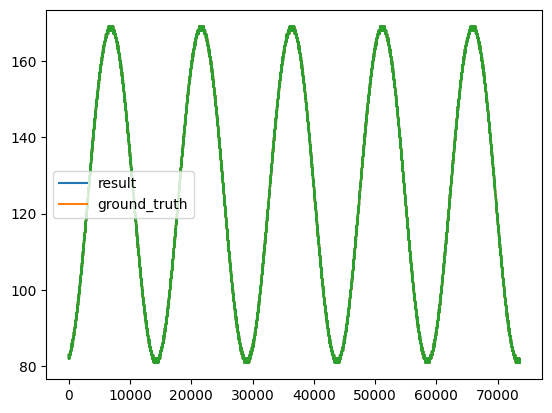

In [3]:
freq0 = 104
freq_gt = 104
clk_freq = 1536000
duration = .3
spikes_window_size = 250
lf_lp_option = 5

base_params = {
    'theta_input': -1,
    'theta': -5,
    'weight_input': 11,
    'weight_feedback': 9,
    'weight': 10,
}
resonator = resonator_from_optuna(**base_params, lf_lp_option=5, clk_freq=clk_freq)
for i in range(0, 5):
    resonator.log_out_spikes(i)
generate_n_input_signal(resonator, duration, freq_gt)
ground_truth = np.array([neuron_output(resonator.neurons[i], spikes_window_size, duration, freq_gt) for i in range(0, 5)])

phase_shift = [0] * 4
for i in range(1, 5):
    j = i - 1
    norm_x0 = (ground_truth[j] - np.min(ground_truth[j]))/(np.max(ground_truth[j]) - np.min(ground_truth[j]))*2-1
    norm_x1 = (ground_truth[i] - np.min(ground_truth[i]))/(np.max(ground_truth[i]) - np.min(ground_truth[i]))*2-1
    phase_shift[j] = np.mean(np.abs((np.arcsin(norm_x0) - np.arcsin(norm_x1)))*180/np.pi)

mse = score_resonator(resonator, duration=.3, freq0=freq_gt, plot=True)
print(f'mse {mse}')

plt.plot(ground_truth[-1])

In [461]:
import time

study_name = f'Study{clk_freq}-{freq0}'
study = optuna.create_study(study_name=study_name,
                            pruner=optuna.pruners.HyperbandPruner(),
                            sampler=TPESampler(seed=43),
                            direction='minimize',
                            load_if_exists=True)

[I 2023-06-14 18:11:10,462] A new study created in memory with name: Study1536000-139


In [462]:
ts = time.time()
study.optimize(objective, n_trials=200)
print(f'{time.time() - ts} seconds.')

[I 2023-06-14 18:11:17,855] Trial 0 finished with value: inf and parameters: {'theta_input': -8.84945433610221, 'theta': -5.864001910807779, 'weight_input': 7.000864462789824, 'weight_feedback': 8.608844299480232, 'weight': 9.907085837167097}. Best is trial 0 with value: inf.
[I 2023-06-14 18:11:18,544] Trial 1 finished with value: 35801.77877240714 and parameters: {'theta_input': -1.4086250905140236, 'theta': -5.008646803529613, 'weight_input': 13.117433184251057, 'weight_feedback': 5.435207366365406, 'weight': 16.006224444204243}. Best is trial 1 with value: 35801.77877240714.
[I 2023-06-14 18:11:19,206] Trial 2 finished with value: inf and parameters: {'theta_input': -6.050499815689942, 'theta': -2.969293220570002, 'weight_input': 8.81631688789819, 'weight_feedback': 5.853274049767277, 'weight': 17.999729613488004}. Best is trial 1 with value: 35801.77877240714.
[I 2023-06-14 18:11:19,858] Trial 3 finished with value: inf and parameters: {'theta_input': -7.789710041156287, 'theta': 

137.36795163154602 seconds.


In [50]:


#
# samples_per_period = 3600
# degree = samples_per_period//360
# cycles = 5
# x0 = np.sin(np.linspace(0, cycles*2*np.pi, samples_per_period*cycles))
# x1 = np.sin(np.pi/2 + np.linspace(0, cycles*2*np.pi, samples_per_period*cycles))
# plt.plot(x0)
# plt.plot(x1)
# np.abs(np.arcsin(x1) - np.arcsin(x0))[0]/np.pi * 180

# for i in range(0, 5):
#     norm_x = (ground_truth[i] - np.min(ground_truth[i]))/(np.max(ground_truth[i]) - np.min(ground_truth[i]))*2-1
#     print(np.arcsin(norm_x)[0]*180/np.pi)

20.07104376653214
36.95972794617341
37.51873119774365
38.0978560212272


In [24]:
-33-45

-78

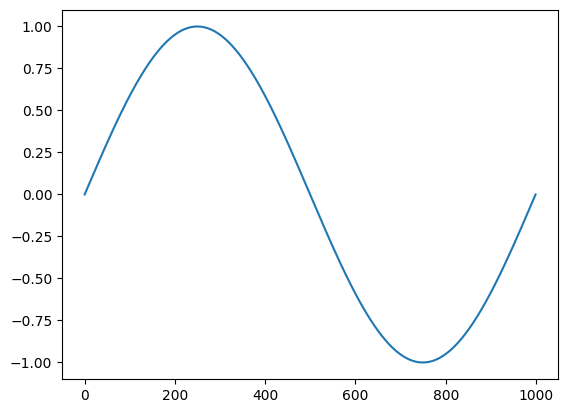

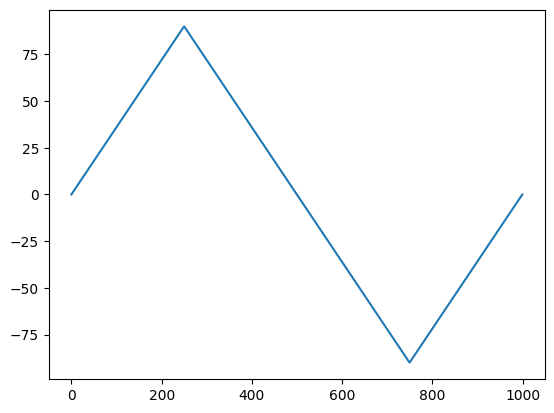

In [22]:
x = np.sin(np.linspace(0, np.pi*2, 1000))
plt.plot(x)
plt.show()
plt.plot(np.arcsin(x)*180/np.pi)

mse 135.41932206477946


{'theta_input': -0.6680591982066444,
 'theta': -3.3734798338935383,
 'weight_input': 15.002698662357943,
 'weight_feedback': 13.386437002207023,
 'weight': 6.953104073362411}

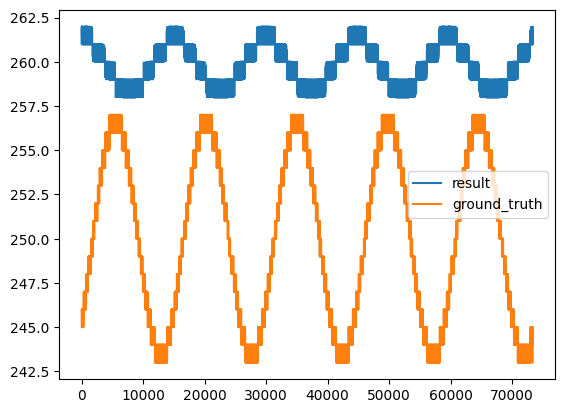

In [463]:
# 118 {'theta_input': -1.161, 'theta': -4.943, 'weight_input': 8.512, 'weight_feedback': 8.867, 'weight': 10.342}
best_params = study.best_params.copy()

resonator = resonator_from_optuna(**best_params, lf_lp_option=lf_lp_option, clk_freq=clk_freq)
# resonator = resonator_from_optuna(**base_params, clk_freq=clk_freq)
mse = score_resonator(resonator, duration=.3, freq0=freq0, plot=True)
print(f'mse {mse}')
best_params

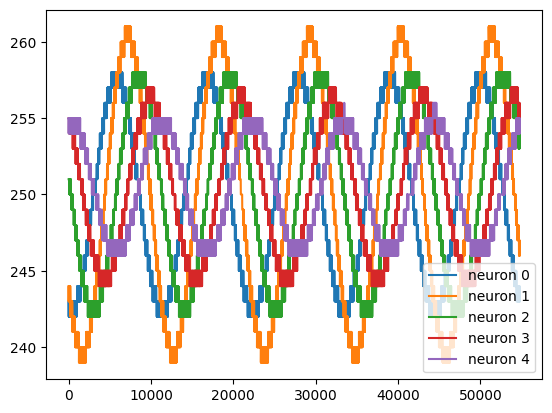

In [454]:
resonator = resonator_from_optuna(**best_params, lf_lp_option=lf_lp_option, clk_freq=clk_freq)
for i in range(len(resonator.neurons)):
    resonator.log_out_spikes(i)

generate_n_input_signal(resonator, duration, freq0)

for i in range(len(resonator.neurons)):
    try:
        normalize_roll = neuron_output(resonator.neurons[i], spikes_window_size, duration, signal_freq=freq0)
        plt.plot(normalize_roll, label=f'neuron {i}')
    except ValueError:
        plt.plot([0], label=f'neuron {i} didnt emit spikes')

plt.legend()


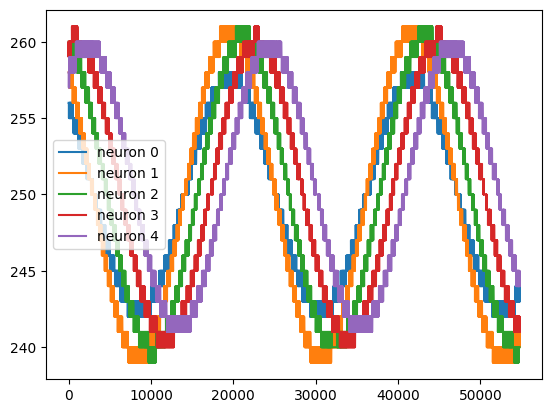

In [455]:
resonator = resonator_from_optuna(**best_params, lf_lp_option=lf_lp_option, clk_freq=clk_freq)
for i in range(len(resonator.neurons)):
    resonator.log_out_spikes(i)


generate_n_input_signal(resonator, duration, freq0/2)

for i in range(len(resonator.neurons)):
    try:
        normalize_roll = neuron_output(resonator.neurons[i], spikes_window_size, duration, signal_freq=freq0)
        plt.plot(normalize_roll, label=f'neuron {i}')
    except ValueError:
        plt.plot([0], label=f'neuron {i} didnt emit spikes')

plt.legend()


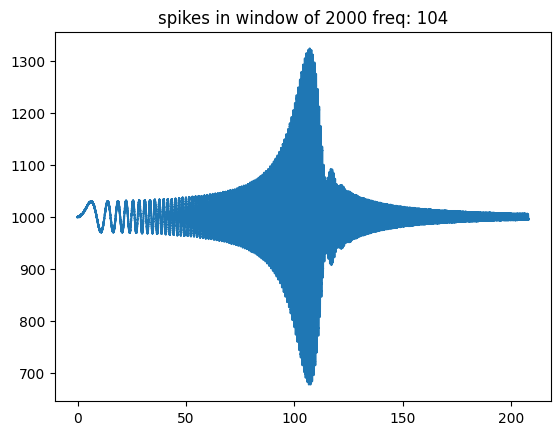

In [483]:
start_freq = 0
spectrum = 2 * freq0
# resonator = resonator_from_optuna(**best_params, lf_lp_option=lf_lp_option, clk_freq=clk_freq)
resonator = resonator_from_optuna(**base_params, lf_lp_option=lf_lp_option, clk_freq=clk_freq)
resonator.log_out_spikes(-1)

step = 1 / 20000
test_size = int(spectrum / step)
test_resonator_on_chirp(
    resonator,
    start_freq=start_freq,
    step=step,
    test_size=test_size,
    clk_freq=clk_freq
)

spikes_neuron = resonator.neurons[-1]
y_events = spikes_neuron.out_spikes()
y_spikes = np.zeros(test_size)
y_spikes[y_events] = 1
spikes_window_size = 500
y_spikes = np.convolve(y_spikes, np.ones(spikes_window_size, dtype=int), 'valid')
x = np.linspace(start_freq, start_freq+spectrum, len(y_spikes))
plt.title(f'spikes in window of {spikes_window_size} freq: {freq0}')
plt.plot(x, y_spikes)
plt.show()

In [348]:
def n0n5_resonator(lf_lp_option, theta_input, theta, weight_input, weight_feedback, weight, amplitude_gain=1, clk_freq=1_536_000):
    LF, LP, f_resonator = _lf_lp_options[lf_lp_option]
    network = SpikingNetwork(clk_freq)
    network.add_amplitude(1000 * amplitude_gain)

    # Encode to pdm
    neuron = create_SCTN()
    neuron.activation_function = IDENTITY
    network.add_layer(SCTNLayer([neuron]))

    neuron = create_SCTN()
    neuron.synapses_weights = np.array([weight_input, -weight_feedback], dtype=np.float64)
    neuron.leakage_factor = LF
    neuron.leakage_period = LP
    neuron.theta = theta_input
    neuron.activation_function = IDENTITY
    neuron.membrane_should_reset = False
    network.add_layer(SCTNLayer([neuron]))

    for i in range(3):
        neuron = create_SCTN()
        neuron.synapses_weights = np.array([weight], dtype=np.float64)
        neuron.leakage_factor = LF
        neuron.leakage_period = LP
        neuron.theta = theta
        neuron.activation_function = IDENTITY
        neuron.membrane_should_reset = False
        network.add_layer(SCTNLayer([neuron]))

    neuron = create_SCTN()
    neuron.synapses_weights = np.array([.5*weight, .5*weight], dtype=np.float64)
    neuron.leakage_factor = LF
    neuron.leakage_period = LP
    neuron.theta = theta
    neuron.activation_function = IDENTITY
    neuron.membrane_should_reset = False
    network.add_layer(SCTNLayer([neuron]))

    # feedback
    network.connect_by_id(4, 1)
    network.connect_by_id(1, 5)
    return network

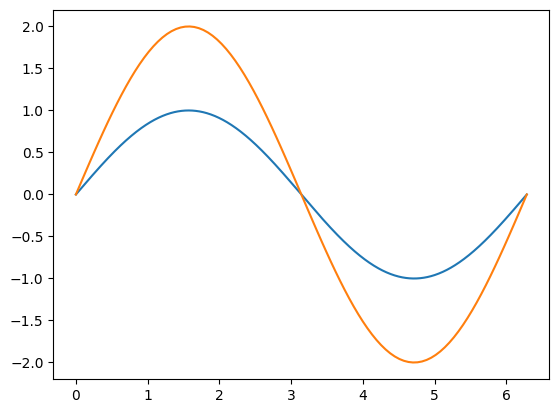

In [424]:
import numpy as np


original_signal = np.sin(np.linspace(0, 2*np.pi, 1000))
interpolated_signal = oversample(original_signal, 100)*2
plt.plot(np.linspace(0, 2*np.pi, 1000), original_signal)
plt.plot(np.linspace(0, 2*np.pi, 100), interpolated_signal)